# MS003 Preprocess
01/10/2024

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
import re

import warnings
warnings.filterwarnings('ignore')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GitHub/afink_lfp_pipeline/LFPAnalysis/')

In [3]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [4]:
# Specify root directory for un-archived data and results 
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/'
anat_dir = f'{base_dir}anat_recons/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir = f'{base_dir}behavior_analysis/behavior_preprocessed/'

subj_id = 'MS003'
subj_format = ['edf']
subj_site = ['MSSM']



# Make mne_data


### Load and resample data


In [6]:
edf_files = glob(f'{neural_dir}{subj_id}raw/*.edf')

mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)


In [7]:
mne_data

<RawEDF | MS003_SWB.edf, 276 x 1281024 (2502.0 s), ~2.63 GB, data loaded>

In [8]:
mne_data.ch_names

['LmOlF1',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'RmOlF1',
 'RmOlF2',
 'RmOlF3',
 'RmOlF4',
 'RmOlF5',
 'RmOlF6',
 'RmOlF7',
 'RmOlF8',
 'RmOlF9',
 'LaCaS1',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'RaCaS1',
 'RaCaS2',
 'RaCaS3',
 'RaCaS4',
 'RaCaS5',
 'RaCaS6',
 'RaCaS7',
 'RaCaS8',
 'RaCaS9',
 'RaCaS10',
 'RaCaS11',
 'RaCaS12',
 'LmCmS1',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmCmS9',
 'LmCmS10',
 'RmCmS1',
 'RmCmS2',
 'RmCmS3',
 'RmCmS4',
 'RmCmS5',
 'RmCmS6',
 'RmCmS7',
 'RmCmS8',
 'RmCmS9',
 'RmCmS10',
 'C63',
 'C64',
 'LalmM1',
 'LalmM2',
 'LalmM3',
 'LalmM4',
 'LalmM5',
 'LalmM6',
 'LalmM7',
 'LalmM8',
 'LalmM9',
 'LalmM10',
 'LalmM11',
 'LalmM12',
 'RalmM1',
 'RalmM2',
 'RalmM3',
 'RalmM4',
 'RalmM5',
 'RalmM6',
 'RalmM7',
 'RalmM8',
 'RalmM9',
 'RalmM10',
 'RalmM11',
 'RalmM12',
 'RalmM13',
 'RalmM14',


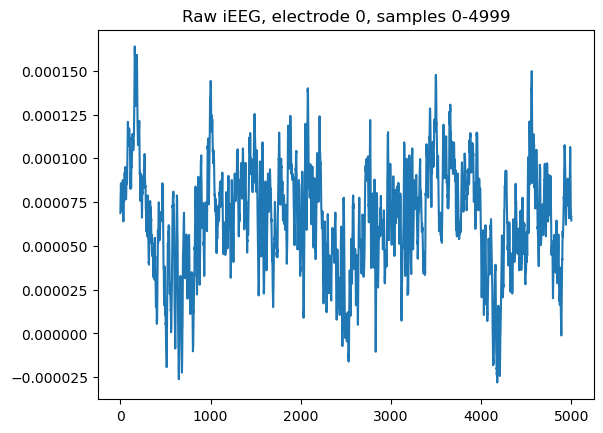

In [9]:
# Sanity check one channel data
plt.plot(mne_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

### Resampling data 


In [10]:
#resampling if patient is not sampled at 512
resample_sr = 500
mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 276 out of 276 | elapsed:   10.5s finished


<RawEDF | MS003_SWB.edf, 276 x 1251000 (2502.0 s), ~2.57 GB, data loaded>

### Photodiode
- examine photodiode 
- save out before resampling/notch filtering *unless nlx - then you have to resample first ### Examine photodiode

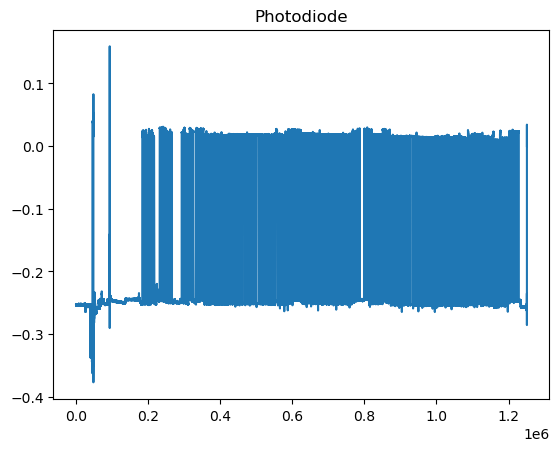

In [12]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index("DC1")
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

In [13]:
mne_data.save(f'{neural_dir}{subj_id}/photodiode.fif', picks='DC1', overwrite=True)

In [14]:
mne_data.drop_channels(['DC1'])

<RawEDF | MS003_SWB.edf, 275 x 1251000 (2502.0 s), ~2.56 GB, data loaded>

### Notch filter line noise


In [15]:
mne_data.info['line_freq'] = 60
# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 275 out of 275 | elapsed:    6.8s finished


<RawEDF | MS003_SWB.edf, 275 x 1251000 (2502.0 s), ~2.56 GB, data loaded>

### Anatomical Localization


In [16]:
### Rename channels to be lowercase before anatomical localization
new_name_dict = {x:x.replace(" ", "").lower() for x in mne_data.ch_names}
mne_data.rename_channels(new_name_dict)

<RawEDF | MS003_SWB.edf, 275 x 1251000 (2502.0 s), ~2.56 GB, data loaded>

In [20]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,ManualExamination,Notes
0,LaCaS1,A13_L,-3.709764,46.512775,-11.687440,-4.844184,33.999416,-13.071413,Gray,Left ACgG anterior cingulate gyrus,Area s32,L Mid Orbital Gyrus,L OrG,Left frontal pole 1 B,NaN,NaN
1,LaCaS10,A9l_L,-7.308108,68.072344,28.268504,-9.890195,54.149132,36.376249,Gray,Left SFG superior frontal gyrus,Unknown,L Superior Frontal Gyrus,L SFG,Unknown,Left superior frontal gyrus 1 B,NaN
2,LaCaS11,A9l_L,-7.308108,70.467851,33.063217,-9.892679,56.415478,42.253481,Unknown,Left SFG superior frontal gyrus,Unknown,L Superior Frontal Gyrus,L SFG,Left superior frontal gyrus 2 C,NaN,NaN
3,LaCaS12,Unknown,-7.707924,71.665605,37.458371,-10.273735,57.347304,47.465558,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,OOB,NaN
4,LaCaS2,A32sg_L,-4.109580,48.908282,-7.691846,-5.555517,36.209189,-7.914435,Gray,Left ACgG anterior cingulate gyrus,Area s32,L ACC,L CG,Left cingulate gyrus D,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,RsifO4,A1/2/3tonIa_R,45.467608,7.785400,15.882161,47.901761,-5.107676,15.077895,Gray,Right CO central operculum,Area OP3 [VS],R Rolandic Operculum,R PoG,Right somatosensory M,NaN,NaN
140,RsifO5,A1/2/3tonIa_R,50.665217,7.785400,16.281720,53.246638,-4.702719,15.720999,White,Right Cerebral White Matter,Unknown,R Rolandic Operculum,R PoG,Unknown,WM,NaN
141,RsifO6,A4hf_R,55.463009,7.785400,16.281720,58.186651,-4.353392,15.814696,White,Right Cerebral White Matter,Unknown,R Rolandic Operculum,R PrG,Right posterior motor J,WM,NaN
142,RsifO7,A1/2/3ulhf_R,60.660618,7.386149,16.681280,63.565237,-4.449542,16.441334,Gray,Right PoG postcentral gyrus,Area 3b,R Postcentral Gyrus,R PoG,Right somatosensory L,NaN,NaN


In [32]:
list(elec_locs.label)

['LaCaS1',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LAglT1',
 'LAglT10',
 'LAglT2',
 'LAglT3',
 'LAglT4',
 'LAglT5',
 'LAglT6',
 'LAglT7',
 'LAglT8',
 'LAglT9',
 'LaImM1',
 'LaImM10',
 'LaImM11',
 'LaImM12',
 'LaImM2',
 'LaImM3',
 'LaImM4',
 'LaImM5',
 'LaImM6',
 'LaImM7',
 'LaImM8',
 'LaImM9',
 'LHplT1',
 'LHplT2',
 'LHplT3',
 'LHplT4',
 'LHplT5',
 'LHplT6',
 'LHplT7',
 'LHplT8',
 'LHplT9',
 'LmCmS1',
 'LmCmS10',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmCmS9',
 'uLmOlF',
 'LmOlF1',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'LsifO1',
 'LsifO2',
 'LsifO3',
 'LsifO4',
 'LsifO5',
 'LsifO6',
 'LsifO7',
 'LsifO8',
 'RaCaS1',
 'RaCaS10',
 'RaCaS11',
 'RaCaS12',
 'RaCaS2',
 'RaCaS3',
 'RaCaS4',
 'RaCaS5',
 'RaCaS6',
 'RaCaS7',
 'RaCaS8',
 'RaCaS9',
 'RAglT1',
 'RAglT10',
 'RAglT2',
 'RAglT3',
 'RAglT4',
 'RAglT5',
 'RAglT6'

In [21]:
#check for any missing channels
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['c63', 'c64', 'lalmm1', 'lalmm2', 'lalmm3', 'lalmm4', 'lalmm5', 'lalmm6', 'lalmm7', 'lalmm8', 'lalmm9', 'lalmm10', 'lalmm11', 'lalmm12', 'ralmm1', 'ralmm2', 'ralmm3', 'ralmm4', 'ralmm5', 'ralmm6', 'ralmm7', 'ralmm8', 'ralmm9', 'ralmm10', 'ralmm11', 'ralmm12', 'ralmm13', 'ralmm14', 'lslfo1', 'lslfo2', 'lslfo3', 'lslfo4', 'lslfo5', 'lslfo6', 'lslfo7', 'lslfo8', 'rslfo1', 'rslfo2', 'rslfo3', 'rslfo4', 'rslfo5', 'rslfo6', 'rslfo7', 'rslfo8', 'fp1', 'f7', 't3', 't5', 'o1', 'f3', 'c3', 'p3', 'fp2', 'f8', 't4', 't6', 'o2', 'f4', 'c4', 'p4', 'fz', 'cz', 'pz', 'ekg1', 'ekg2', 'c166', 'c167', 'c168', 'c169', 'c170', 'c171', 'c172', 'c173', 'c174', 'c175', 'c176', 'c177', 'c178', 'c179', 'c180', 'c181', 'c182', 'c183', 'c184', 'c185', 'c186', 'c187', 'c188', 'c189', 'c190', 'c191', 'c192', 'c193', 'c194', 'c195', 'c196', 'c197', 'c198', 'c199', 'c200', 'c201', 'c202', 'c203', 'c204', 'c205', 'c206', 'c207', 'c208', 'c209', 'c210', 'c211', 'c212', 'c213', 'c214', 'c215', 'c216', 'c217', 'c218', '

In [22]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)


Number of electrodes in the mne file is greater than the number of electrodes in the localization file


In [23]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}


In [24]:
new_name_dict #make sure this passes the eye test 

{'lmolf1': 'lmolf1',
 'lmolf2': 'lmolf2',
 'lmolf3': 'lmolf3',
 'lmolf4': 'lmolf4',
 'lmolf5': 'lmolf5',
 'lmolf6': 'lmolf6',
 'lmolf7': 'lmolf7',
 'lmolf8': 'lmolf8',
 'lmolf9': 'lmolf9',
 'rmolf1': 'rmolf1',
 'rmolf2': 'rmolf2',
 'rmolf3': 'rmolf3',
 'rmolf4': 'rmolf4',
 'rmolf5': 'rmolf5',
 'rmolf6': 'rmolf6',
 'rmolf7': 'rmolf7',
 'rmolf8': 'rmolf8',
 'rmolf9': 'rmolf9',
 'lacas1': 'lacas1',
 'lacas2': 'lacas2',
 'lacas3': 'lacas3',
 'lacas4': 'lacas4',
 'lacas5': 'lacas5',
 'lacas6': 'lacas6',
 'lacas7': 'lacas7',
 'lacas8': 'lacas8',
 'lacas9': 'lacas9',
 'lacas10': 'lacas10',
 'lacas11': 'lacas11',
 'lacas12': 'lacas12',
 'racas1': 'racas1',
 'racas2': 'racas2',
 'racas3': 'racas3',
 'racas4': 'racas4',
 'racas5': 'racas5',
 'racas6': 'racas6',
 'racas7': 'racas7',
 'racas8': 'racas8',
 'racas9': 'racas9',
 'racas10': 'racas10',
 'racas11': 'racas11',
 'racas12': 'racas12',
 'lmcms1': 'lmcms1',
 'lmcms2': 'lmcms2',
 'lmcms3': 'lmcms3',
 'lmcms4': 'lmcms4',
 'lmcms5': 'lmcms5',
 

In [26]:
unmatched_seeg #make sure there are no unmatched names

[]

In [25]:
# Rename the mne data according to the localization data
mne_data.rename_channels(new_name_dict)

<RawEDF | MS003_SWB.edf, 275 x 1251000 (2502.0 s), ~2.56 GB, data loaded>

In [27]:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of {len(left_seeg_names)} left sEEG and {len(right_seeg_names)} right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')



We have a total of 70 left sEEG and 72 right sEEG electrodes
We have a total of 142 sEEG electrodes


In [28]:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
mne_data.set_channel_types(sEEG_mapping_dict)

<RawEDF | MS003_SWB.edf, 275 x 1251000 (2502.0 s), ~2.56 GB, data loaded>

In [30]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names))
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs + 1 (photodiode)

<RawEDF | MS003_SWB.edf, 142 x 1251000 (2502.0 s), ~1.32 GB, data loaded>

In [31]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | MS003_SWB.edf, 142 x 1251000 (2502.0 s), ~1.32 GB, data loaded>

## Signal Cleaning 
Methods:
- Remove all channels that are obviously noise
- Be LIBERAL with bad labeling - these channels are NOT removed from the dataset, they are just NOT USED to rereference other channels. 
- This process is iterative depending on how TFRs look. 

In [32]:
lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict) #this is way too lenient - only run to compare not to use as only cleaning tool

['lmcms2',
 'lmolf8',
 'racas10',
 'racas11',
 'raimm4',
 'rmcms1',
 'rmcms4',
 'rmcms5',
 'rmcms6',
 'rmcms8',
 'rsifo7',
 'rsifo8']

In [35]:
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)

In [36]:
probe_names

array(['lacas', 'laglt', 'laimm', 'lhplt', 'lmcms', 'lmolf', 'lsifo',
       'racas', 'raglt', 'raimm', 'rhplt', 'rmcms', 'rmolf', 'rsifo',
       'ulmolf', 'urmolf'], dtype='<U6')

In [37]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [38]:
probe_ch_counts

{'lacas': 12,
 'laglt': 10,
 'laimm': 12,
 'lhplt': 9,
 'lmcms': 10,
 'lmolf': 9,
 'lsifo': 8,
 'racas': 12,
 'raglt': 10,
 'raimm': 14,
 'rhplt': 9,
 'rmcms': 10,
 'rmolf': 9,
 'rsifo': 8,
 'ulmolf': 1,
 'urmolf': 1}

<IPython.core.display.Javascript object>


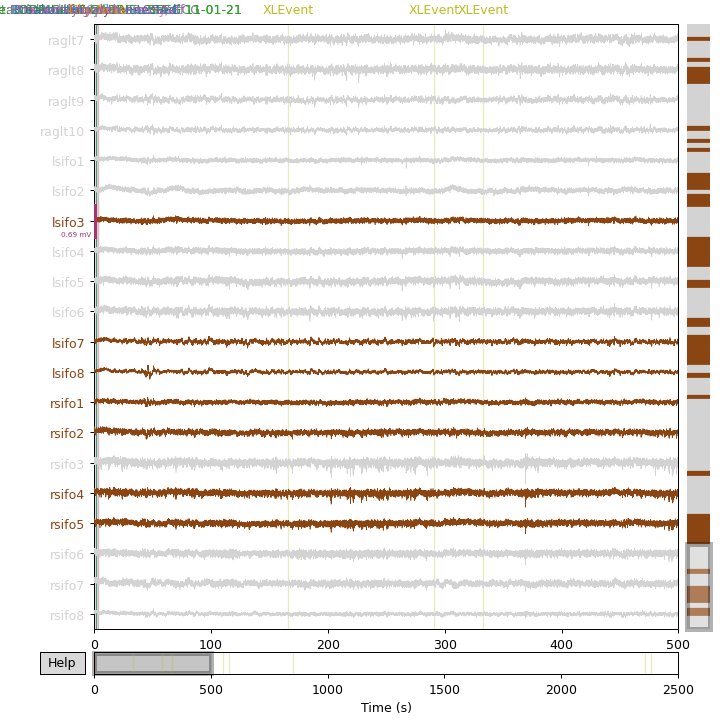

<IPython.core.display.Javascript object>


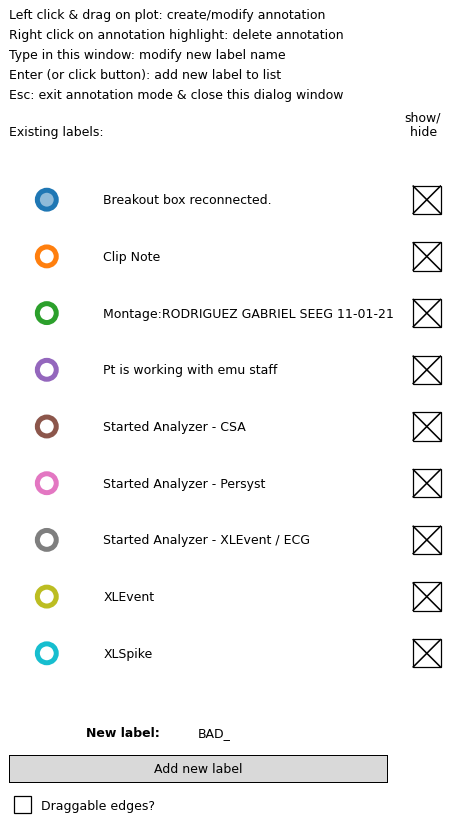

In [39]:
%matplotlib notebook 

fig = mne_data.plot(start=0, duration=500, n_channels=20, scalings=mne_data._data.max()/50)
fig.fake_keypress('a')

In [40]:
mne_data.info['bads']

['lmolf8',
 'rmolf1',
 'rmolf6',
 'rmolf7',
 'rmolf8',
 'rmolf9',
 'lacas1',
 'lmolf1',
 'lmolf2',
 'lmolf3',
 'lmolf5',
 'lmolf6',
 'lmolf7',
 'lacas2',
 'lacas3',
 'lacas5',
 'lacas11',
 'lacas4',
 'lacas6',
 'lacas8',
 'racas1',
 'lacas9',
 'lmcms3',
 'racas10',
 'lmcms2',
 'lmcms7',
 'lmcms6',
 'lmcms5',
 'lmcms4',
 'racas2',
 'racas3',
 'racas4',
 'racas5',
 'laimm1',
 'laimm2',
 'laimm3',
 'laimm4',
 'rmcms6',
 'rmcms7',
 'rmcms8',
 'lmcms8',
 'laimm5',
 'laimm7',
 'laimm11',
 'raimm8',
 'raimm7',
 'laimm10',
 'laimm6',
 'raimm10',
 'raimm11',
 'raimm12',
 'raimm13',
 'lhplt1',
 'lhplt2',
 'lhplt3',
 'lhplt4',
 'lhplt5',
 'lhplt6',
 'lhplt7',
 'lhplt8',
 'lhplt9',
 'rhplt1',
 'rhplt2',
 'rhplt3',
 'rhplt4',
 'rhplt5',
 'rhplt6',
 'rhplt7',
 'rhplt8',
 'laglt1',
 'laglt2',
 'laglt3',
 'laglt4',
 'laglt5',
 'laglt6',
 'laglt7',
 'laglt8',
 'laglt9',
 'raglt8',
 'raglt7',
 'raglt9',
 'raglt10',
 'lsifo1',
 'lsifo2',
 'rsifo3',
 'rsifo7',
 'rsifo8',
 'rsifo6',
 'lsifo4',
 'lsifo5',
 

In [41]:
#set bad channel info 
mne_data.info['bads'] = ['lmolf8','rmolf1','rmolf6','rmolf7','rmolf8','rmolf9','lacas1','lmolf1',
'lmolf2','lmolf3','lmolf5','lmolf6','lmolf7','lacas2','lacas3','lacas5','lacas11',
'lacas4','lacas6','lacas8','racas1','lacas9','lmcms3','racas10','lmcms2','lmcms7',
'lmcms6','lmcms5','lmcms4','racas2','racas3','racas4','racas5','laimm1','laimm2',
'laimm3','laimm4','rmcms6','rmcms7','rmcms8','lmcms8','laimm5','laimm7','laimm11',
'raimm8','raimm7','laimm10','laimm6','raimm10','raimm11','raimm12','raimm13','lhplt1',
'lhplt2','lhplt3','lhplt4','lhplt5','lhplt6','lhplt7','lhplt8','lhplt9','rhplt1',
'rhplt2','rhplt3','rhplt4','rhplt5','rhplt6','rhplt7','rhplt8','laglt1','laglt2',
'laglt3','laglt4','laglt5','laglt6','laglt7','laglt8','laglt9','raglt8','raglt7',
'raglt9','raglt10','lsifo1','lsifo2','rsifo3','rsifo7','rsifo8','rsifo6','lsifo4',
'lsifo5','lsifo6']

In [44]:
mne_data.info #sanity check that bads info saved

<Info | 10 non-empty values
 bads: 91 items (lmolf8, rmolf1, rmolf6, rmolf7, rmolf8, rmolf9, ...)
 ch_names: lmolf1, lmolf2, lmolf3, lmolf4, lmolf5, lmolf6, lmolf7, lmolf8, ...
 chs: 142 sEEG
 custom_ref_applied: False
 dig: 142 items (142 EEG)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 250.0 Hz
 meas_date: 2001-01-01 10:06:23 UTC
 nchan: 142
 projs: []
 sfreq: 500.0 Hz
>

# Re-referencing 
- wm reref
- bipolar reref

In [45]:
#run if only re-ref
anat_file = glob(f'{anat_dir}/{subj_id}_labels.csv')[0]
# mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif', preload=True)

### WM REF

In [46]:
# Re-reference neural data
mne_data_wm_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                              elec_path=anat_file, 
                                              method='wm', 
                                              site='MSSM')

Number of electrodes in the mne file is less than the number of electrodes in the localization file


In [47]:
mne_data_wm_reref

<RawEDF | MS003_SWB.edf, 113 x 1251000 (2502.0 s), ~1.05 GB, data loaded>

In [48]:
mne_data_wm_reref.ch_names

['lacas1-laimm8',
 'lacas10-laimm8',
 'lacas2-laimm8',
 'lacas3-laimm8',
 'lacas4-laimm8',
 'lacas5-laimm8',
 'lacas6-laimm8',
 'lacas7-laimm8',
 'lacas8-laimm8',
 'lacas9-laimm8',
 'laglt1-lsifo3',
 'laglt2-lsifo3',
 'laglt3-lsifo3',
 'laglt4-lsifo3',
 'laglt5-lsifo3',
 'laglt6-lsifo3',
 'laglt7-lsifo3',
 'laglt8-lsifo3',
 'laglt9-lsifo3',
 'laimm1-lsifo3',
 'laimm10-lsifo3',
 'laimm11-lsifo3',
 'laimm2-lsifo3',
 'laimm3-lsifo3',
 'laimm4-lsifo3',
 'laimm5-lsifo3',
 'laimm6-lsifo3',
 'laimm7-lsifo3',
 'lhplt1-lsifo3',
 'lhplt2-lsifo3',
 'lhplt3-lsifo3',
 'lhplt4-lsifo3',
 'lhplt5-lsifo3',
 'lhplt6-lsifo3',
 'lhplt7-lsifo3',
 'lhplt8-lsifo3',
 'lmcms2-laimm8',
 'lmcms3-laimm8',
 'lmcms4-laimm8',
 'lmcms5-laimm8',
 'lmcms6-laimm8',
 'lmcms7-laimm8',
 'lmcms8-laimm8',
 'lmcms9-laimm8',
 'lmolf1-laimm8',
 'lmolf2-lsifo3',
 'lmolf3-lsifo3',
 'lmolf4-lsifo3',
 'lmolf5-lsifo3',
 'lmolf6-lsifo3',
 'lmolf7-lsifo3',
 'lmolf8-lsifo3',
 'lsifo1-lsifo3',
 'lsifo2-lsifo3',
 'lsifo4-lsifo3',
 'lsifo

In [49]:
mne_data_wm_reref.save(f'{neural_dir}{subj_id}/wm_ref_ieeg.fif',overwrite=True)

###  BIPOLAR REF

In [50]:
# Re-reference neural data
mne_data_bp_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                              elec_path=anat_file, 
                                              method='bipolar', 
                                              site='MSSM')

Number of electrodes in the mne file is less than the number of electrodes in the localization file


In [51]:
mne_data_bp_reref

<RawEDF | MS003_SWB.edf, 27 x 1251000 (2502.0 s), ~257.8 MB, data loaded>

In [52]:
mne_data_bp_reref.ch_names

['lacas7-lacas10',
 'lmcms1-lmcms9',
 'lsifo3-lsifo7',
 'racas6-racas7',
 'racas7-racas8',
 'racas8-racas9',
 'racas9-racas11',
 'raglt1-raglt2',
 'raglt2-raglt3',
 'raglt3-raglt4',
 'raglt5-raglt6',
 'raimm1-raimm2',
 'raimm2-raimm3',
 'raimm3-raimm4',
 'raimm4-raimm5',
 'raimm5-raimm6',
 'raimm6-raimm9',
 'rmcms1-rmcms2',
 'rmcms2-rmcms3',
 'rmcms3-rmcms4',
 'rmcms4-rmcms5',
 'rmcms5-rmcms9',
 'rmolf2-rmolf3',
 'rmolf3-rmolf4',
 'rsifo1-rsifo2',
 'rsifo2-rsifo4',
 'rsifo4-rsifo5']

In [53]:
mne_data_bp_reref.save(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',overwrite=True)

## Save mne_data

In [54]:
mne_data.save(f'{neural_dir}{subj_id}/raw_ieeg.fif',overwrite=True)

# Epoching + TFRs
- Check whether data is ready to be analyzed - if this step shows noise then steps above should be repeated
- Align photodiode to behavior 
- Epoch data (and mark bad epochs)
- Baseline data
- Visualize TFRs 

In [55]:
#remove mne_data from environment to save memory 
del mne_data, mne_data_bp_reref, mne_data_wm_reref

In [10]:
####add directory for TFRs
anat_file = glob(f'{anat_dir}/{subj_id}_labels.csv')[0]
tfr_dir = f'{base_dir}ephys_analysis/figs/TFRs/{subj_id}/all_trials/'
os.makedirs(tfr_dir,exist_ok = True) #added so you don't have to manually make subject folders in clean_data
date = '01102024' #add date to file name --- update every run!

#load behavior data
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
behav_df = behav_df[behav_df['FeedbackOnset'] != 0] #remove fail trials from behav df
beh_ts = behav_df['TrialOnset'] #timestamp that should be aligned to photodiode 
#load photodiode data
photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

In [11]:
tfr_dir

'/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/figs/TFRs/MS003/all_trials/'

### Photodiode Alignment

In [12]:
### Photodiode alignment

# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            photodiode_data, 
                                            smoothSize=11, windSize=15, height=0.7)

11 blocks
...........

found matches for 75 of 170 pulses


In [14]:
print(slope, offset)

0.9999921147640637 -6.513586207892331


## Epoch Data
- Epoch neural data into trial epochs 
- Add behavioral data to epochs metadata
- Save epochs
- Baseline + decompose data into TFRs
- Plot + save TFRs (examine quality)

In [15]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}

In [16]:
# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0], #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [0, 5.0]} #1 sec decision period + 2 second outcome + 3 second counterfactual

In [17]:
epochs_all_evs = {f'{x}': np.nan for x in evs}

In [18]:
### MAKE SURE CORRECT REREF FILE IS BEING USED!
for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/wm_ref_ieeg.fif', 
#     ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/bp_ref_ieeg.fif', 
                 slope=slope, offset=offset,
                 behav_name=event, behav_times=behav_df[event].values, 
                 ev_start_s=evs[event][0], ev_end_s=evs[event][1], buf_s = 1.0, IED_args=IED_args) #1.0 buf unsaved

    epochs_all_evs[event] = ev_epochs
    

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 113 out of 113 | elapsed:    4.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 113 out of 113 | elapsed:    6.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 113 out of 113 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 113 out of 113 | elapsed:    3.0s finished


In [20]:
epochs_all_evs 

{'TrialOnset': <Epochs |  147 events (all good), -2 - 1 sec, baseline off, ~190.4 MB, data loaded, with metadata,
  'TrialOnset': 147>,
 'DecisionOnset': <Epochs |  147 events (all good), -1 - 6 sec, baseline off, ~443.9 MB, data loaded, with metadata,
  'DecisionOnset': 147>}

### Add behavioral data to metadata 

In [21]:
behav_df

,Round,Trial Num,TrialType,TrialOnset,ChoiceOnset,DecisionOnset,FeedbackOnset,RT,SafeBet,LowBet,...,totalCPE,decisionCPE,totalRegret,decisionRegret,totalRelief,decisionRelief,totalCF,decisionCF,pRPE,nRPE
0,1,97.0,gain,672.233587,672.243938,676.379679,678.399482,4.135741,0.6,0.00,...,-1.90,-0.60,-1.90,-0.60,0.00,0.00,1.90,0.60,0.000,-0.95
1,2,2.0,mix,683.445664,683.446437,686.689719,688.716539,3.243281,0.0,-0.30,...,0.39,0.09,0.00,0.00,0.39,0.09,-0.30,0.00,0.195,0.00
2,3,141.0,loss,692.985923,692.992102,697.634177,697.641242,4.642075,-0.6,-1.01,...,0.41,0.41,0.00,0.00,0.41,0.41,-1.01,-1.01,0.000,0.00
3,4,90.0,gain,709.306608,709.307324,712.794498,712.801611,3.487175,0.5,0.00,...,0.50,0.50,0.00,0.00,0.50,0.50,0.00,0.00,0.000,0.00
4,5,22.0,mix,720.051674,720.059262,724.355490,726.382110,4.296228,0.0,-1.10,...,-1.32,-1.10,-1.32,-1.10,0.00,0.00,0.22,0.00,0.000,-0.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,88.0,gain,2412.096003,2412.096821,2413.824209,2413.831479,1.727388,0.5,0.00,...,-1.30,-1.30,-1.30,-1.30,0.00,0.00,1.80,1.80,0.000,0.00
146,147,44.0,mix,2421.221671,2421.222379,2423.553517,2425.568175,2.331139,0.0,-1.10,...,-2.20,-1.10,-2.20,-1.10,0.00,0.00,1.10,0.00,0.000,-1.10
147,148,82.0,gain,2436.098357,2436.104349,2440.013423,2440.020402,3.909074,0.5,0.00,...,-0.41,-0.41,-0.41,-0.41,0.00,0.00,0.91,0.91,0.000,0.00
148,149,4.0,mix,2447.536598,2447.537405,2449.974451,2451.994053,2.437046,0.0,-0.30,...,0.46,0.16,0.00,0.00,0.46,0.16,-0.30,0.00,0.230,0.00


In [22]:
behav_params = ['SafeBet', 'LowBet', 'HighBet','GambleChoice', 'Outcome',
                'Profit', 'TotalProfit', 'GambleEV', 'CR', 'choiceEV', 'RPE',
                'totalCPE', 'decisionCPE', 'totalRegret', 'decisionRegret',
                'totalRelief', 'decisionRelief', 'totalCF', 'decisionCF', 'pRPE','nRPE']

In [23]:
for event in evs.keys():

    event_metadata = epochs_all_evs[event].metadata.copy()
    
    #independent vars
    for param in behav_params: 
        event_metadata[param] = behav_df[param].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

In [24]:
epochs_all_evs[event].metadata

,lacas1-laimm8,lacas10-laimm8,lacas2-laimm8,lacas3-laimm8,lacas4-laimm8,lacas5-laimm8,lacas6-laimm8,lacas7-laimm8,lacas8-laimm8,lacas9-laimm8,...,totalCPE,decisionCPE,totalRegret,decisionRegret,totalRelief,decisionRelief,totalCF,decisionCF,pRPE,nRPE
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.90,-0.60,-1.90,-0.60,0.00,0.00,1.90,0.60,0.000,-0.95
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.39,0.09,0.00,0.00,0.39,0.09,-0.30,0.00,0.195,0.00
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.41,0.41,0.00,0.00,0.41,0.41,-1.01,-1.01,0.000,0.00
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.50,0.50,0.00,0.00,0.50,0.50,0.00,0.00,0.000,0.00
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.32,-1.10,-1.32,-1.10,0.00,0.00,0.22,0.00,0.000,-0.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.30,-1.30,-1.30,-1.30,0.00,0.00,1.80,1.80,0.000,0.00
143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.20,-1.10,-2.20,-1.10,0.00,0.00,1.10,0.00,0.000,-1.10
144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.41,-0.41,-0.41,-0.41,0.00,0.00,0.91,0.91,0.000,0.00
145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.46,0.16,0.00,0.00,0.46,0.16,-0.30,0.00,0.230,0.00


### Save raw epoched data 


In [25]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/wm_epoch_{event}.fif', overwrite=True)
#     epochs_all_evs[event].save(f'{neural_dir}{subj_id}/bp_epoch_{event}.fif', overwrite=True)

### Baseline + Decompose into TFRs

In [26]:
# Explicitly define a list of analysis events and the baseline event. Should correspond to the dict
analysis_evs = ['DecisionOnset']
baseline_ev = 'TrialOnset'
evs = {'TrialOnset': [-1.0, 0], #maybe increase to full second to take cycles up to 4
       #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [0, 5.0]} #1 sec decision period + 2 second outcome + 3 second counterfactual

In [27]:
# Set some spectrogram parameters 
freqs = np.logspace(*np.log10([2, 200]), num=30)
n_cycles = 3
sr = 500.0 
buf = 1.0
buf_ix = int(buf*sr)

In [28]:
epochs_all_baseline = {} #removed unecessary 'decisiononset' empty key

In [29]:
#baseline epoch - 
event = 'TrialOnset'
epochs = epochs_all_evs[event]

good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

for ch_ix in np.arange(epochs._data.shape[1]): 
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    bad_epochs  = np.where(epochs.metadata[epochs.ch_names[ch_ix]].notnull())[0]
    good_epochs = np.delete(np.arange(ch_data.shape[0]), bad_epochs)
    ch_data = np.delete(ch_data, bad_epochs, axis=0)
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                        freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=1)

    pow_struct[good_epochs, ch_ix, :, :] = ch_pow[:, 0, :, :]

temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)
temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])

epochs_all_baseline[event] = temp_pow


In [30]:
epochs_all_baseline

{'TrialOnset': <EpochsTFR | time : [-1.000000, 0.000000], freq : [2.000000, 200.000000], epochs : 147, channels : 113, ~1.86 GB>}

In [31]:
power_epochs = {}

In [32]:
event = 'DecisionOnset'

epochs = epochs_all_evs[event]

# Let's make sure we only do this for good channels
good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

for ch_ix in np.arange(epochs._data.shape[1]): 
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    bad_epochs  = np.where(epochs.metadata[epochs.ch_names[ch_ix]].notnull())[0] 
    good_epochs = np.delete(np.arange(ch_data.shape[0]), bad_epochs)
    ch_data = np.delete(ch_data, bad_epochs, axis=0) #this is where bad epochs for ch are deleted!!
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                        freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=1)

    pow_struct[good_epochs, ch_ix, :, :] = ch_pow[:, 0, :, :]

temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)

temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])


baseline_corrected_power = lfp_preprocess_utils.baseline_trialwise_TFR(data=temp_pow.data, 
                                                  baseline_mne=epochs_all_baseline['TrialOnset'], 
                                                  mode='zscore', 
                                                  trialwise=True, ## make sure this is true!
                                                  baseline_only=False)


zpow = mne.time_frequency.EpochsTFR(epochs.info, baseline_corrected_power, 
                                temp_pow.times, freqs)

zpow.metadata = epochs_all_evs[event].metadata

power_epochs[event] = zpow



In [33]:
power_epochs['DecisionOnset']

<EpochsTFR | time : [0.000000, 5.000000], freq : [2.000000, 200.000000], epochs : 147, channels : 113, ~9.29 GB>

In [34]:
#conda install -c conda-forge h5io must install to save tfr data
# power_epochs['DecisionOnset'].save(f'{neural_dir}{subj_id}/bp_pow_epochs-tfr.h5', overwrite=True)
power_epochs['DecisionOnset'].save(f'{neural_dir}{subj_id}/wm_pow_epochs-tfr.h5', overwrite=True)


# Plot TFRs

In [35]:
event = 'DecisionOnset'
yticks = [4, 12, 30, 60, 90, 120, 150, 180, 200]
good_ch = [x for x in power_epochs[event].ch_names if '-' in x]
save_path = tfr_dir
# date = '01102024' #add date to file name 


for ch in good_ch:
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    times = power_epochs[event].times
    plot_data = np.nanmean(np.nanmean(power_epochs[event].copy().pick_channels([ch]).data, axis=0), axis=0)

    im = ax.imshow(plot_data,
            extent=[times[0], times[-1], freqs[0], freqs[-1]], interpolation='Bicubic',
            aspect='auto', origin='lower', cmap='RdBu_r',vmin = -np.nanmax(np.abs(plot_data)), vmax = np.nanmax(np.abs(plot_data)))
    ax.set(yticks=yticks, xlabel='Time (s)', ylabel='Frequency',title=f'{ch} Encoding')
    ax.yaxis.set_tick_params(labelsize=8)
    fig.colorbar(im, ax=ax)
    plt.savefig(f'{save_path}{ch}_{date}_wm_ref.png', format='png', metadata=None,
#     plt.savefig(f'{save_path}/{ch}_{date}_bp_ref.png', format='png', metadata=None,
    bbox_inches=None, pad_inches=0.1,
    facecolor='auto', edgecolor='auto',
    backend=None)
    plt.close()
